In [1]:
import sys
#Install packages prefer conda if you are using anaconda otherwise try with pip, uncomment only if install is needed (if you use Google colab pip should work)

#conda:
#os.system('conda install GPy -c conda-forge')
#os.system('conda install GPyOpt -c conda-forge')

#pip:
#!{sys.executable} -m pip install GPy
#!{sys.executable} -m pip install GPyOpt
import numpy as np
import matplotlib.pyplot as plt
import GPyOpt
from torchvision import datasets, transforms, utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
import random

np.random.seed(32)
random.seed(32)

# Hyperparameters tuning using Bayesian Optimization with the GPyOpt library

As you are going to see, the project for this first part of the course will be to use Bayesian Optimization to tune the hyperparameters of a Deep Neural Network. To do that you are going to use a library that is more optimized compare to the code from scratch that we have written before. We are going to use [GPyOPt](https://sheffieldml.github.io/GPyOpt/) developed by the Machine Learning group of the University of Sheffield and it is based on GPy, which is a framework for using Gaussian Process in Python.

In this exercise you are going to use Bayesian Optimization to select the best hyperparameters of a random forest trained on part of the MNIST dataset. You are going also to compare it with respect to a random search on the hyperparameter space.


In [4]:
def load_MNIST():
    '''
    Function to load the MNIST training and test set with corresponding labels.

    :return: training_examples, training_labels, test_examples, test_labels
    '''

    training_set = datasets.MNIST(root='./data', train=True, download=True, transform= None)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform= None)

    x_train = training_set.data.numpy().reshape(-1,28*28)
    x_test = test_set.data.numpy().reshape(-1,28*28)

    y_train = training_set.targets.numpy()
    y_test = test_set.targets.numpy()

    return x_train, y_train, x_test, y_test

In [5]:
## since training a random forest on the entire dataset takes some time
## we can consider only few labels, like 3, 5, 8 and 9

## we can load the training set and test set
Xtrain, ytrain, Xtest, ytest = load_MNIST()

## we use a mask to selects those subsets
#train_filter = np.isin(ytrain, [3, 5, 8, 9])
#test_filter = np.isin(ytest, [3, 5, 8, 9])

# apply the mask to the entire dataset
#Xtrain, ytrain = Xtrain[train_filter], ytrain[train_filter]
#Xtest, ytest = Xtest[test_filter], ytest[test_filter]

# print some information
print('Information about the new datasets')
print('Training set shape:', Xtrain.shape)
print('Test set shape', Xtest.shape)

Information about the new datasets
Training set shape: (60000, 784)
Test set shape (10000, 784)


## Random forest

As you have seen in your Machine Learning course, there are a lot of hyperparameters to choose before training a Random Forest. If you look at the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) you can notice all the paramters. For this exercise we will focus only on the following four hyperparameters:

1. **n_estimators**: the number of decision trees that are in the forest;
2. **criterion**: the criterion to evaluate the split. We should decide between *Gini impurity* (`gini`) and *information gain* (`entropy`);
3. **max_depth**: Maximum depth of the trees. If None, the tree expands until we have a element in all the leaves or  until all leaves contain less than min_samples_split samples.
4. **max_features**: The number of features to consider when looking for the best split. We have to choose among `'sqrt'` where we consider `sqrt(n_features)`, `'log2'` where we consider `log2(n_features)`. It is possible to use `None` where we consider all the features, but it makes everything super slow, so we are avoiding it.

Remember that when we are using Random Forest we can avoid running the cross-validation to get the validation error as approximation of the test error, but instead we can use the *out of bag* error to get an approximation of the test error we are going to get when we consider unseen example. 

<font color='blue'> Tasks:
1. You should define a `RandomForestClassifier` with default parameters, and compute the *out_of_bag* error (you should use `oob_score=True` when you define the classifier) and then the test error. This would be the baseline for the experiment.

In [6]:
model = RandomForestClassifier(oob_score=True)
model.fit(Xtrain, ytrain)
print('Default model out of bag error', model.oob_score_)
print('Default model test accuracy', model.score(Xtest, ytest))

Default model out of bag error 0.9657833333333333
Default model test accuracy 0.9696


### Random search 

A possible way to find the best hyperparameters is to use random search over the parameter space. To perform this operation we can use `RandomizedSearchCV`. You can look at the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). However, since we do not need cross-validation for Random Forests, we can use `ParameterSampler` to sample random parameters from our parameter space. Look at the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html#sklearn.model_selection.ParameterSampler) To be able to use this method you should first define a dictionary of the hyperparameters you want to optimize, in this case the four we mentioned above, and then decide a way to evaluate the model and how many folds for the cross-validation. The dictionary is of the form:

```python
params = {"name_params": uniform(0, 1), # if it is continuous between 0 and 1
           "name_params2": range(1,50), # if it is discrete but integer
           "name_params3": ['name1', 'name2']} # if it is discrete but string`
```

<font color='blue'> Tasks:

1. <font color='blue'> Crete the dictionary of the hyperparameters, we recommend keeping the value of the number of trees less than 100 otherwise it takes a very long time. You can try to increase it at home, but it will likely not be possible in the exercise session as you would be stuck for some time. After that, you can use the dictionary to create a random hyperparameter using `ParameterSampler`. The `ParameterSampler` call is already provided.

2. <font color='blue'> Using the parameters returned by the `ParameterSampler` you should fit a random forest, and for each iteration you should store the best value of the `model.oob_score_` you get. **HINT:** You can access the hyperparameters value by the name you used in the defined dictionary. (The whole process would take like 5/10 mins)

In [7]:
import time 

# hyperparams dictionary 
domain = {"n_estimators": range(1, 101), 
          "criterion": ['gini', 'entropy'],
          "max_depth": range(10, 60, 5),
          "max_features": ['sqrt', 'log2']}
#rs = RandomizedSearchCV(model, param_distributions=domain, cv=3, verbose =2, n_iter=10)
#rs.fit(Xtrain, ytrain)

# create the ParameterSampler
param_list = list(ParameterSampler(domain, n_iter=20, random_state=32))
print('Param list')
print(param_list)
#rounded_list = [dict((k,v) for (k, v) in d.items()) for d in param_list]

#print('Random parameters we are going to consider')
#print(rounded_list)

## now we can train the random forest using these parameters tuple, and for
## each iteration we store the best value of the oob

current_best_oob = 0
iteration_best_oob = 0 
max_oob_per_iteration = []
i = 0
for params in param_list:
    print(i)
    print(params)
    model = RandomForestClassifier(n_estimators= params['n_estimators'], criterion = params['criterion'], 
                           max_depth = params['max_depth'], max_features = params['max_features'], oob_score=True, n_jobs=-1)

    start = time.time()
    model.fit(Xtrain, ytrain)
    end = time.time()
    model_oob = model.oob_score_
    print('OOB found:', model_oob)
    if model_oob > current_best_oob:
        current_best_oob = model_oob
        iteration_best_oob = i
    
    max_oob_per_iteration.append(current_best_oob)
    i += 1
    print(f'It took {end - start} seconds')
    

Param list
[{'n_estimators': 76, 'max_features': 'log2', 'max_depth': 25, 'criterion': 'entropy'}, {'n_estimators': 80, 'max_features': 'log2', 'max_depth': 45, 'criterion': 'gini'}, {'n_estimators': 74, 'max_features': 'log2', 'max_depth': 55, 'criterion': 'entropy'}, {'n_estimators': 35, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'gini'}, {'n_estimators': 41, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'entropy'}, {'n_estimators': 37, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}, {'n_estimators': 76, 'max_features': 'sqrt', 'max_depth': 45, 'criterion': 'entropy'}, {'n_estimators': 53, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'gini'}, {'n_estimators': 44, 'max_features': 'log2', 'max_depth': 35, 'criterion': 'entropy'}, {'n_estimators': 11, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini'}, {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'entropy'}, {'n_estimators': 44, 'max_features': 'sqrt'

### Bayesian Optimization

The procedure we are interested in, instead, is Bayesian Optimization. As before, also for GPyOpt, we should start by defining the set of hyperparameters you want to optimize. If some hyperparameters are discrete and represented by a string, you should integer instead and change them when you are initializing the classifier. The dictionary should have this form `{'name': 'name_of_params', 'type': 'type_of_variable', 'domain': domain_given_as_tuple}`. Note that the domain should specify as tuple. An example is given by

```python
params = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,10)},
            {'name': 'var_2', 'type': 'discrete', 'domain': (0,5,10)},
            {'name': 'var_3', 'type': 'categorical', 'domain': (0,1)}]`
```

In the example above, suppose that `'var_3'` is usually used as string, where `0 = 'l1'` and `1 = 'l2'`, for example.
If you want to define a large discrete interval, you should define the tuple as `tuple(np.arange(1,100,1, dtype= np.int))`. 

The second ingredient we should define is the objective function we want to maximize. Since GPyOpt minimize things, when you are returning the value of the objective you return it negated. This function, usually defined as `objective_function(x)`, takes a general parameter `x`. This represents all the parameter we need. Therefore, when we define the function, we should collect the parameters by doing `param = x[0]`. Then we are able to pass the parameters to the classifier. In the example above we will have that `param[0]` is the 'var_1', `param[0]` is 'var_2', whereas, since 'var_3' is usually a string we should get back the string value, therefore `if param[2] == 0: var_3 = l1 else: var_3 = 'l2'`.
Note that by default GPyOpt initializes with 5 points and considers Bayesian optimization after this, therefore max_iter=15 will give you a total of 20 function evaluation. 
In a general way, the scheme for the objective function is similar to:

```python
def objective_function(x):

    param = x[0]
    
    if param[2] == 1:
        val_3 = 'l1'
    else:
        val_3 = 'l2'
        
    model = your_model(param[0],param[1],val_3)
    model.fit(X,y)
    
    ## then you will compute the measure you want to maximize
    ## usually you should consider a validation set
    ## in case of random forest you return the - oob score
    return - model.score(Xvalid, yvalid)
```

In case of random forest, you should return the `oob_score` and not the validation score. If you are going to use other models you should consider the validation set, instead.

When you have these two ingredients, you should create an Bayesian Optimization instancer using the following function `GPyOpt.methods.BayesianOptimization`, see the complete description [here](https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html). Run it calling the `run_optimization` function of this instance, documentation [here](https://gpyopt.readthedocs.io/en/latest/GPyOpt.core.html).

At the end of the optimization, you can access the array of the best parameters by `x_best = opt.X[np.argmin(opt.Y)]`. You can also collect the best `oob_score` per iteration using 
`y_bo = np.maximum.accumulate(-opt.Y).ravel()`.


<font color='blue'> Tasks:

1. <font color='blue'>You should define all the ingredients needed for GPyOpt: 1) define the dictionary of hyperparameters, following the GPyOpt rules; 2) define the objective function you want to optimize. GPyOpt usually minimize (there is a parameter called maximize but it appears to have no effect), therefore, since in your setting you want to maximize the oob_score, you should return the negative oob_score; 3) run the optimization. When you create the `GPyOpt.methods.BayesianOptimization` instance you should define the following parameters: `f`,`domain`, `acquisition_type`, `exploration_weight`. The documentation for the GPyOpt package is quite limited and it is quite unclear to define how to define certain parameter, so elaborate hints are given here. The fitting procedure should take $\sim 10$ minutes. Do not worry about the warning "The set cost function is ignored! LCB acquisition does not make sense with cost." which might occur when using LCB. From discussions on github it appears to be a known error and might be fixed in the lastest git master branch.

2. <font color='blue'>In the same plot, show the best `oob_score` per iteration you obtain using the random search and the bayesian optimization. What do you see?

    

In [8]:
## define the domain of the considered parameters
n_estimators = tuple(np.arange(1,101,1, dtype= np.int))
# print(n_estimators)
max_depth = tuple(np.arange(10,110,10, dtype= np.int))
# max_features = ('log2', 'sqrt', None)
max_features = (0, 1)
# criterion = ('gini', 'entropy')
criterion = (0, 1)


# define the dictionary for GPyOpt
domain = [{'name': 'n_estimators', 'type': 'discrete', 'domain':n_estimators},
          {'name': 'max_depth', 'type': 'discrete', 'domain': max_depth},
          {'name': 'max_features', 'type': 'categorical', 'domain': max_features},
          {'name': 'criterion', 'type': 'categorical', 'domain': criterion}]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    #print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    param = x[0]
    print(param)
    # we have to handle the categorical variables
    if param[2] == 0:
        max_f = 'log2'
    elif param[2] == 1:
        max_f = 'sqrt'
    else:
        max_f = None

    if param[3] == 0:
        crit = 'gini'
    else:
        crit = 'entropy'

    #create the model
    model = RandomForestClassifier(n_estimators = int(param[0]), max_depth = int(param[1]), max_features= max_f, criterion = crit, oob_score=True, n_jobs=-1)
    
    # fit the model 
    model.fit(Xtrain, ytrain)
    print(model.oob_score_)
    return - model.oob_score_


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = 'EI' ,      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 15) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
    x_best[2])  + ", criterion=" + str(
    x_best[3]))

[27. 50.  0.  0.]
0.9324166666666667
[80. 40.  1.  1.]
0.9633666666666667
[99. 10.  0.  1.]
0.9343333333333333
[32. 20.  1.  0.]
0.9502833333333334
[76. 20.  1.  1.]
0.9633
[80. 40.  1.  1.]
0.9635333333333334
[79. 40.  1.  0.]
0.9637666666666667
[68. 30.  1.  1.]
0.9621
[88. 70.  1.  0.]
0.9647
[100.  90.   0.   0.]
0.961
[72. 90.  1.  0.]
0.96335
[62. 10.  1.  0.]
0.9367833333333333
[78. 30.  1.  0.]
0.9635666666666667
[74. 60.  1.  0.]
0.9635333333333334
[78. 80.  0.  1.]
0.9582666666666667
[93. 60.  1.  0.]
0.9653666666666667
[ 57. 100.   1.   0.]
0.96085
[ 80. 100.   1.   0.]
0.9639
[100.  70.   1.   1.]
0.9645833333333333
[  1. 100.   1.   1.]
0.36711666666666665
The best parameters obtained: n_estimators=93.0, max_depth=60.0, max_features=1.0, criterion=0.0


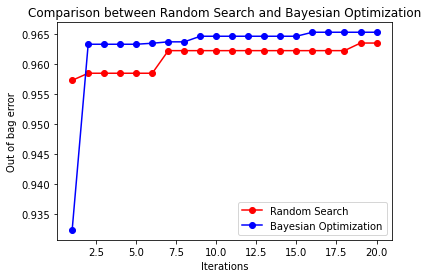

In [9]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO, note that it is also provided by GPOpt in Y_Best
y_bo = np.maximum.accumulate(-opt.Y).ravel()
# define iteration number
xs = np.arange(1,21,1)

plt.plot(xs, max_oob_per_iteration, 'o-', color = 'red', label='Random Search')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Out of bag error')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

# [OPTIONAL] Investigate the acquisition function (not part of the exam)
<br>
<font color='blue'>
1. <font color='blue'> Investigate the dimensionality of the GP (look at the model subclass), how many dimensions are there? Why?
 
2.<font color='blue'> Take a look at the acqusition function, as this is more than 2 dimensional in this case it is not trivial to plot it, therefore keep the categorical variables fixed at some value that you decide and evaluate the acquisition function on a grid for the remaining two variables. The acquisition function can be evaluated using opt.acquisition.acquisition_function and you can create the grid using np.meshgrid. 

In [ ]:
#We start by taking a look a the model subclass of our Bayesian optimization object
print(opt.model.input_dim)
#so there is 6 dimensions, that is 1 for each of n_estimators and depth which are discrete variables.
# the remaining 4 is because one-out-of-K encoding is using for the categorical variables max_features and criterion
#we can also look at kernel parameters
print(opt.model.get_model_parameters_names())
#and get the current fitted values
print(opt.model.get_model_parameters())
#To get a plot of the acquisition function we use the function opt.acquisition.acquisition_function
#first we define a sensible grid for the first to parameters 
#indexing='ij' ensures that x/y axes are not flipped (which is default):
#we also add two extra axes for the categorical varibles and here fix these to 0 ('log2' and 'gini')
#note that the acqusition function can actually take any value not only integers as it lives in the GP space (here 0.5 intervals)
#and it is quite fast to evaluate - here in 40000 points
n_feat = np.arange(1,101,0.5)
max_d = np.arange(10,110,0.5)
pgrid = np.array(np.meshgrid(n_feat, max_d,[1],[0],[1],[0],indexing='ij'))
print(pgrid.reshape(6,-1).T.shape)
#we then unfold the 4D array and simply pass it to the acqusition function
acq_img = opt.acquisition.acquisition_function(pgrid.reshape(6,-1).T)
#it is typical to scale this between 0 and 1:
acq_img = (-acq_img - np.min(-acq_img))/(np.max(-acq_img - np.min(-acq_img)))
#then fold it back into an image and plot
acq_img = acq_img.reshape(pgrid[0].shape[:2])
plt.figure()
plt.imshow(acq_img.T, origin='lower',extent=[n_feat[0],n_feat[-1],max_d[0],max_d[-1]])
plt.colorbar()
plt.xlabel('n_features')
plt.ylabel('max_depth')
plt.title('Acquisition function');